# Object counting using 2-connected components - bees #


This notebook presents the best result of comparison between effects of application of some connectivity algorithms (for bees counting): approximative version of k_components.

## Table of contents:
##### 1. Import of modules
##### 2. Transformation an image into a graph
##### 3. Visualization of the effects of segmentation
##### 4. Preparing image
##### 5. Object counting 

## 1. Import of modules##

In [1]:
from PIL import Image, ImageFilter, ImageEnhance
from skimage import io, filters,measure
import cv2
import numpy as np
import networkx as nx
from graphviz import Graph
from networkx.algorithms import approximation as apxa
from random import randint,random
import matplotlib.pyplot as plt
import glob, os
from datetime import timedelta
import time

## 2. Transformation an image into a graph ##

In [2]:
def define_nodes(graph, shape):
    for i in range(shape[0]):
        for j in range(shape[1]):
            graph.add_node((i, j)) 

In [3]:
def abs_value(image_arr, x1, y1, x2, y2): 
    return abs(image_arr[x1, y1] - image_arr[x2, y2])

In [4]:
def define_edges(graph, image_arr, shape, max_degree, diff=abs_value,p=0):
    if max_degree==4:
        for i in range(shape[0]):
            for j in range(shape[1]):
                if i - 1 >= 0 and diff(image_arr,i,j,i-1,j)<=p:
                    graph.add_edge((i, j), (i-1, j), weight=diff(image_arr,i,j,i-1,j))
                if j - 1 >= 0 and diff(image_arr,i,j,i,j-1)<=p:
                    graph.add_edge((i, j), (i, j-1), weight=diff(image_arr,i,j,i,j-1))
    if max_degree==8:
        for i in range(shape[0]):
            for j in range(shape[1]):
                if i - 1 >= 0 and diff(image_arr,i,j,i-1,j)<=p:
                    graph.add_edge((i, j), (i-1, j), weight=diff(image_arr,i,j,i-1,j))
                if j - 1 >= 0 and diff(image_arr,i,j,i,j-1)<=p:
                    graph.add_edge((i, j), (i, j-1), weight=diff(image_arr,i,j,i,j-1))
                if i - 1 >= 0 and j - 1 >= 0 and diff(image_arr,i,j,i-1,j-1)<=p:
                    graph.add_edge((i, j), (i-1, j-1), weight=diff(image_arr,i,j,i-1,j-1))
                if i - 1 >= 0 and j + 1 < shape[0] and diff(image_arr,(i,j),(i-1,j+1))<=p:
                    graph.add_edge((i, j), (i-1, j+1), weight=diff(image_arr,i,j,i-1,j+1))

## 3. Visualization of the effects of segmentation  ##

In [5]:
def get_result_channel_random_quart(shape, components):
    volumes = []
    for comp in components:
        volumes.append(len(comp))

    quart_1=np.quantile(volumes,0.25,axis=0)
    quart_3=np.quantile(volumes,0.75,axis=0)
    k_down=1.5
    k_up=1.5

    t_down=quart_1-k_down*(quart_3-quart_1)
    t_up=quart_3+k_up*(quart_3-quart_1)
    
    
    big_comp=[]
    small_comp=[]
    for i in range(len(volumes)):
        if volumes[i]>t_up:
            big_comp.append(i)
        if volumes[i]<t_down:
            small_comp.append(i)
    normal_comp = [item for item in range(0,len(volumes)) if item not in small_comp and item not in big_comp]
    print("After: "+str(len(normal_comp))) 
    im=Image.new('RGB', (channel.shape[1], channel.shape[0]))
    result=im.load()
    random_color = lambda: (int(random()*255), int(random()*255), int(random()*255))
    colors = [random_color() for i in range(len(two_connected_components))]
    colors = [random_color() for i in range(len(components))]
    i=0
    for component in components:
        if i in normal_comp:
            for pair in component:
                result[pair[1],pair[0]] = colors[i]
        i+=1     
    return im

In [6]:
def reject_comp_movie(big_set,t_down):
    big_set.remove(max(big_set, key=len))
    big_set.remove(max(big_set, key=len))
    reject_set=[]
    for comp in big_set:
        if len(comp)<=t_down:
            reject_set.append(comp)
    normal_comp = [item for item in big_set if item not in reject_set]
    return normal_comp

In [7]:
def reject_comp(big_set,t_down,t_up):
    big_set.remove(max(big_set, key=len))
    reject_set=[]
    for comp in big_set:
        if len(comp)<=t_down:
            reject_set.append(comp)
        elif len(comp)>=t_up:
            reject_set.append(comp)
    normal_comp = [item for item in big_set if item not in reject_set]
    return normal_comp

In [8]:
def median(bicomponents):
    volume=[]
    for comp in bicomponents:
        volume.append(len(comp))
    return np.quantile(volume,0.5,axis=0)

In [9]:
def get_result_channel_random(channel, two_connected_components):
    im=Image.new('RGB', (channel.shape[1], channel.shape[0]))
    result=im.load()
    random_color = lambda: (int(random()*255), int(random()*255), int(random()*255))
    colors = [random_color() for i in range(len(two_connected_components))]
    i=0
    for component in two_connected_components:
        for pair in component:
            result[pair[1],pair[0]] = colors[i]
        i+=1
    return im

## 4. Preparing image

In [10]:
frames=[]
os.chdir('.\pictures_of_bees')
for file in glob.glob('*.png'):
    frames.append(Image.open(file))
for file in glob.glob('*.jpg'):
    frames.append(Image.open(file))

In [11]:
def converting_to_binary(image):
    gray = cv2.cvtColor(image,cv2.COLOR_RGB2GRAY)
    ret, thresh = cv2.threshold(gray,0,255,cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    contours, hierarchy = cv2.findContours(thresh,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
    for cnt in contours:
        cv2.drawContours(thresh,[cnt],0,255,-1)
    kernel = np.ones((3,3),np.uint8)
    opening = cv2.morphologyEx(thresh,cv2.MORPH_OPEN, kernel,iterations=2)
    return opening

In [12]:
def scaling_image(image,shape):
    if(shape[0]>700 or shape[1]>700):
        scale_percent = 70 
        width = int(shape[0] * scale_percent / 100)
        height = int(shape[1] * scale_percent / 100)
        new_shape= (width, height)    
        image = image.resize(new_shape)    
    return image

## 5. Bees counting ##

In [13]:
def two_connected_components_movie_bees(image_number,max_degree=4, diff=abs_value, p=0):
    start_time = time.monotonic()

    bees = frames[image_number]
    img=scaling_image(bees,bees.size)
    f=plt.figure(figsize=(13,11))
    f1=f.add_subplot(3,2,1)
    f1=plt.title("Original image in BGR")
    f1=plt.imshow(img)

    enhanced_image=ImageEnhance.Contrast(img).enhance(1.2)
    enhanced_image=ImageEnhance.Brightness(enhanced_image).enhance(1.05)
    enhanced_image=ImageEnhance.Sharpness(enhanced_image).enhance(0.95)
 
    f2=f.add_subplot(3,2,2)
    f2=plt.title("Enhanced image")
    f2=plt.imshow(enhanced_image)

    image_arr = np.array(enhanced_image, dtype='int16')
    channel_r = image_arr[:,:,0]
#     b = image_arr.copy()
#     b[:, :, 0] = 0
#     b[:, :, 1] = 0
    r_im= Image.fromarray(channel_r)
    r_gray= r_im.convert('L') 
    f3=f.add_subplot(3,2,3)
    f3=plt.title("Red channel of image in grayscale")
    f3=plt.imshow(r_gray)

    bw = r_gray.point(lambda x: 0 if x<86 else 255, '1')
    f4=f.add_subplot(3,2,4)
    f4=plt.title("Binary version of red channel")
    f4=plt.imshow(bw) 

    image_arr = np.array(bw, dtype='int16')
    graph = nx.Graph()
    define_nodes(graph, image_arr.shape)
    define_edges(graph, image_arr, image_arr.shape, max_degree, diff, p)
    comps = apxa.k_components(graph)
    comps = comps[2]   

    result1 = get_result_channel_random(image_arr,comps)    
    f5=f.add_subplot(3,2,5)
    f5=plt.title("Before rejecting: "+str(len(comps)-1))
    f5=plt.imshow(result1) 

    p=median(comps)
    comps_smaller=reject_comp_movie(comps,int(p/2))
    result2 = get_result_channel_random(image_arr, comps_smaller)
    f6=f.add_subplot(3,2,6)
    f6=plt.title("After rejecting: "+str(len(comps_smaller)))
    f6=plt.imshow(result2)

    end_time = time.monotonic()
    print("Time="+str(timedelta(seconds = end_time - start_time)))
    plt.show()

## Pictures from movie

Time=0:00:06.500000


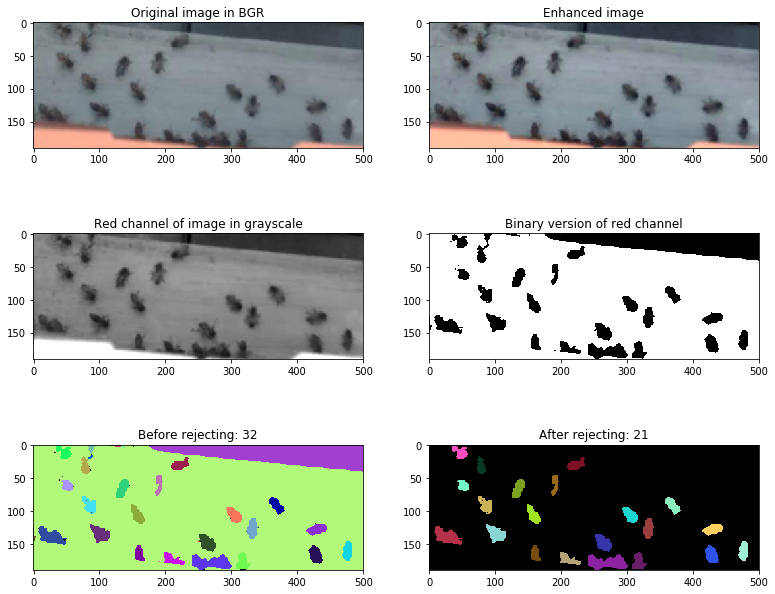

In [14]:
two_connected_components_movie_bees(2)

Time=0:00:06.954000


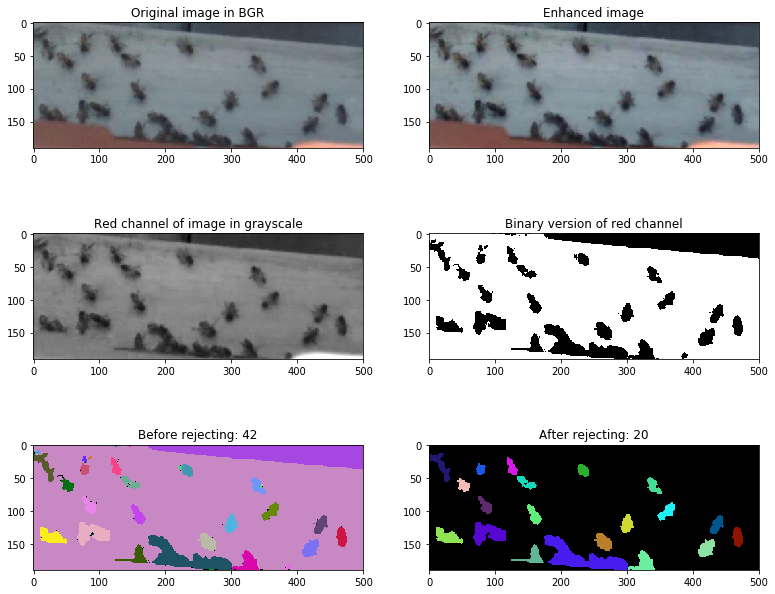

In [15]:
two_connected_components_movie_bees(3)

Time=0:00:06.625000


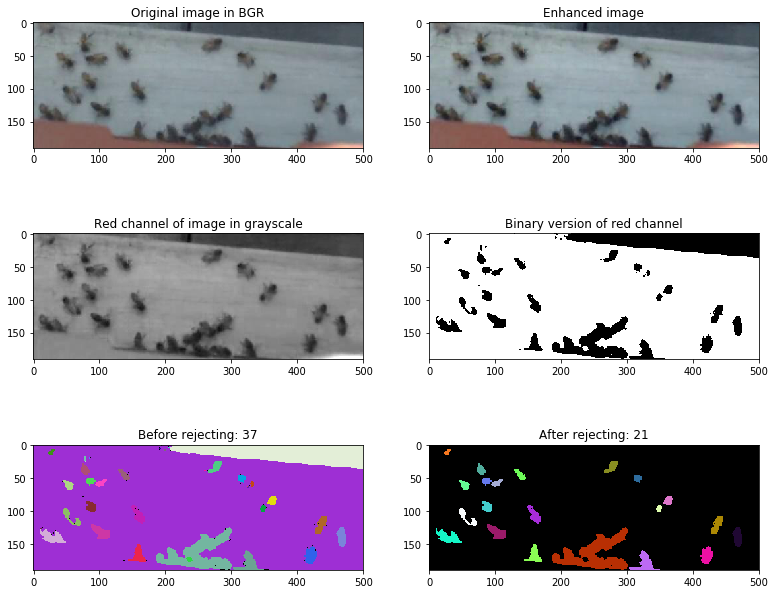

In [16]:
two_connected_components_movie_bees(4)

Time=0:00:06.937000


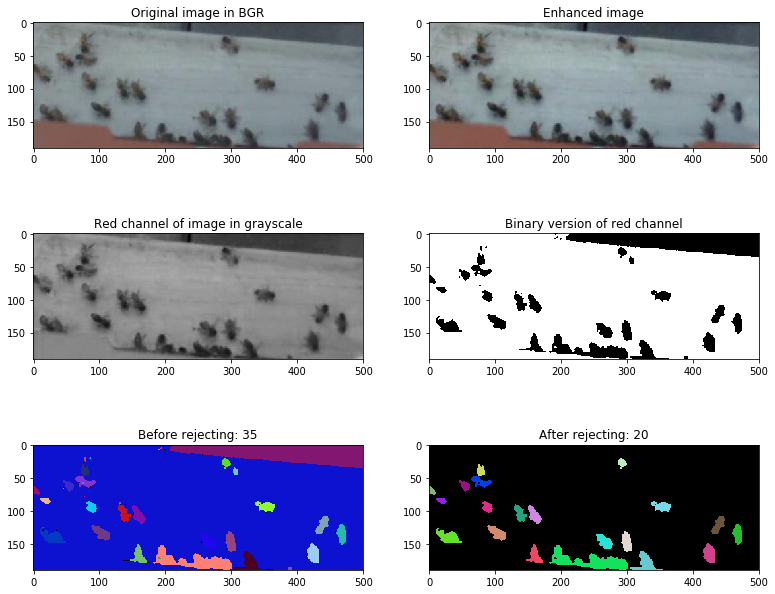

In [17]:
two_connected_components_movie_bees(5)

Time=0:00:08.703000


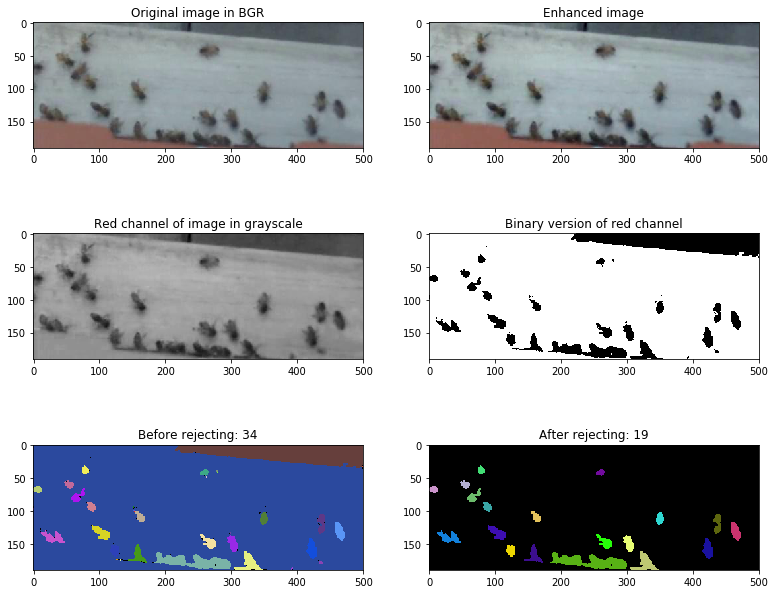

In [18]:
two_connected_components_movie_bees(6)

## Generated images

In [19]:
def two_connected_components_generated_bees(image_number, rejecting = "median", max_degree=4, diff=abs_value, p=0):
    start_time = time.monotonic()

    bees = frames[image_number]
    img=scaling_image(bees,bees.size)
    f=plt.figure(figsize=(11,7))
    f1=f.add_subplot(2,2,1)
    f1=plt.imshow(img)  

    contrast=ImageEnhance.Contrast(img).enhance(1.4)
    image = cv2.cvtColor(np.array(contrast), cv2.COLOR_RGB2BGR)  
    image=converting_to_binary(image)
    image = Image.fromarray(image)
    f2=f.add_subplot(2,2,2)
    f2=plt.imshow(image)
    
    image_arr = np.array(image, dtype='int16')
    graph = nx.Graph()
    define_nodes(graph, image_arr.shape)
    define_edges(graph, image_arr, image_arr.shape, max_degree, diff, p)
    
    comps = apxa.k_components(graph)
    comps = comps[2]   
    result1 = get_result_channel_random(image_arr,comps)    
    f3=f.add_subplot(2,2,3)
    f3=plt.title("Before: "+str(len(comps)-1))
    f3=plt.imshow(result1) 
    
    if rejecting == "quartile":
        result2=get_result_channel_random_quart(image_arr.shape, comps)
        f4=f.add_subplot(2,2,4)
    elif rejecting == "median":
        p=median(comps)
        comps_smaller=reject_comp(comps,int(p/2), int(4*p))
        result2 = get_result_channel_random(image_arr, comps_smaller)
        f4=f.add_subplot(2,2,4)
        f4=plt.title("After: "+str(len(comps_smaller)))
    f4=plt.imshow(result2)
    end_time = time.monotonic()
    print("Time="+str(timedelta(seconds = end_time - start_time)))
    plt.show()

Time=0:00:19.141000


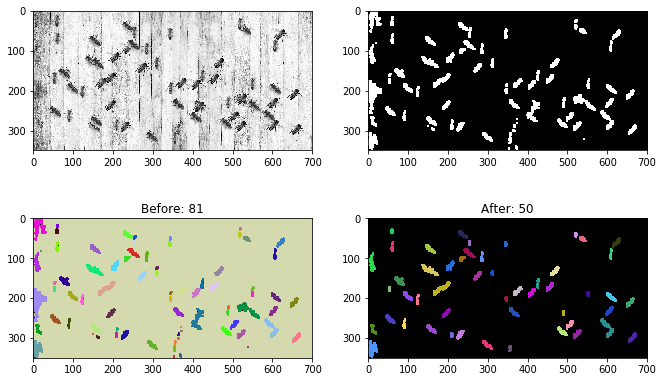

In [20]:
two_connected_components_generated_bees(0)

Time=0:00:33.610000


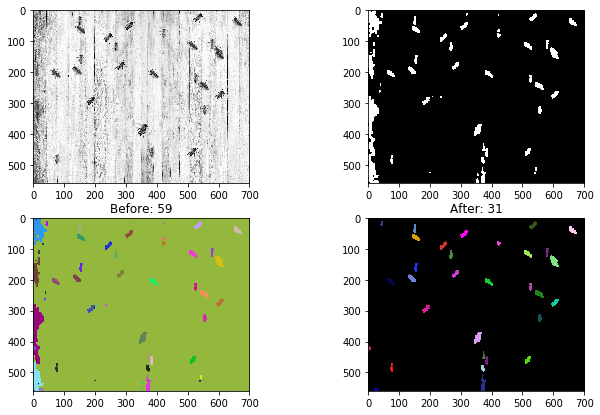

In [21]:
two_connected_components_generated_bees(1)